# **CS 1674/2074: Assignment 5**

Please, follow the instructions below:

## Part I: Edge detection and circle detection (60 points)

![title](images/egg.jpg)

In this problem, you will implement a Hough Transform circle detector that takes an input image and a fixed radius, and returns the centers of any detected circles of about that size. You are not allowed to use any built-in Python functions for finding edges or circles!

The following function is provided on Github repo:

* `def detect_edges(img, threshold) return edges` -- A function to compute edges in an image. Converts to grayscale first, computes gradients, then computes the gradient magnitude and orientation at each pixel, and only returns those (x, y) locations with magnitude that is higher than the threshold. The function also displays the final thresholded edge image.

    Inputs:
    * `img` is the RGB input image of class `uint8`, and
    * `threshold` is a user-set threshold for detecting edges (which can be omitted if you want to use the default threshold-- to use that, only supply the first input to the function).

    Output:
    * `edges` is an Nx4 matrix containing 4 numbers for each of N detected edge points: N(i, 1) is the x location of the point, N(i, 2) is the y location of the point, N(i, 3) is the gradient magnitude at the point, and N(i, 4) is the gradient orientation (non-quantized) at the point.
Include the following in your submission:

1. [40 pts - autograder] `def detect_circles(img, edges, radius, top_k) return centers`-- A function to find and visualize circles given an edge map.

    Inputs:
    * `img`, `edges` are defined as above,
    * `radius` specifies the size of circle we are looking for (hover the mouse over the image and visually approximate the radius), and
    * `top_k` says how many of the top-scoring circle center possibilities to show and output.
      
    Output:
    * `centers` is an Nx2 matrix in which each row lists the x, y position of a detected circle's center.

    **Tips:**
    * Since we use `np.arctan` to compute gradient orientation in radians, make sure you use `np.cos` and `np.sin` to detect circles. 
    * Consider using `np.ceil(a / quantization_value) and np.ceil(b / quantization_value)` (where, for example, quantization_value can be set to 5) to easily figure out quantization/bins in Hough space. Don't forget to multiply by quantization_value once you've figured out the Hough parameters with most votes, to find out the actual x, y location corresponding to the selected bin. `Quantization_value is the size of our bins.
    * You can use these two lines at the end of your function to visualize circles: `for i in range(a.shape[0]): img = cv2.circle(img, (centers[0][i], centers[1][i]), radius, (255, 0, 0), 2)`
    * You can ignore circles whose centers are outside the image.
2. [20 pts - manually graded] Demonstrate the function applied to the provided images `jupiter.jpg` and `egg.jpg` from the Github repo. Display the images with detected circle(s), on the visualizations cell below.

A sample image is shown below.

![title](images/jupiter_ans.png)

In [22]:
import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

def energy_image(img):
    img_gray    = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    img_gray    = img_gray.astype(np.float32)

    filt        = np.array([1,0,-1])
    Ix          = ndimage.convolve(img_gray, filt[np.newaxis,:], mode='constant')

    Iy          = ndimage.convolve(img_gray, filt[:,np.newaxis], mode='constant')

    energyImage = np.sqrt(np.power(Ix,2) + np.power(Iy,2))

    return energyImage, Ix, Iy, img_gray

def detect_edges(img, threshold, display = True):
    _, Ix, Iy, img = energy_image(img)

    grad_mag    = np.sqrt(Ix**2, Iy**2)

    grad_orient = np.arctan(Iy/ Ix) #* 180/np.pi

    edge_inds   = np.where(grad_mag >= threshold)
    edge_mag    = grad_mag[edge_inds]
    edge_orient = grad_orient[edge_inds]
    edges       = [edge_inds[1], edge_inds[0], edge_mag, edge_orient]

    
    not_edge_inds = grad_mag < threshold
    img[not_edge_inds] = 0
    img[edge_inds] = edge_mag

    img = np.where(img>255,255,img)
    img = np.where(img<0,0,img)
    img = img.astype(np.uint8)

    if display == True:
        cv2.imshow('edge image', img)
        cv2.waitKey(0)

    return edges

def detect_circles(img, edges, radius, top_k, display =True):
    quantization_value = 5
    height, width = img.shape[:2]
    H = np.zeros((int(np.ceil(height / quantization_value)), int(np.ceil(width / quantization_value))))

    for i in range(len(edges[0])):
        x = edges[0][i]
        y = edges[1][i]
        gradient = edges[3][i] 
        a = x - (radius * np.cos(gradient))
        b = y - (radius * np.sin(gradient)) 

        a_quant = int(np.ceil(a / quantization_value))
        b_quant = int(np.ceil(b / quantization_value)) 

        if 0 <= a_quant < H.shape[0] and 0 <= b_quant < H.shape[1]:
            H[a_quant, b_quant] += 1 

    sort_indices = np.argsort(H.ravel())
    top_k_indices = np.unravel_index(sort_indices[-top_k:], H.shape)

    centers = []
    for index in range(len(top_k_indices[0])):
        a = top_k_indices[0][index]
        b = top_k_indices[1][index] 
        center_x = int(a * quantization_value)
        center_y = int(b * quantization_value) 

        if 0 <= center_x < width and 0 <= center_y < height:
            centers.append((center_x, center_y))

    for center in centers:
        img = cv2.circle(img, center, radius, (255, 0, 0), 2)
        
    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
    return np.array(centers)


/var/folders/0r/_23lrllj19g0qr50g0hcm52w0000gn/T/ipykernel_91894/683137487.py:26: RuntimeWarning: divide by zero encountered in divide
  grad_orient = np.arctan(Iy/ Ix) #* 180/np.pi
/var/folders/0r/_23lrllj19g0qr50g0hcm52w0000gn/T/ipykernel_91894/683137487.py:26: RuntimeWarning: invalid value encountered in divide
  grad_orient = np.arctan(Iy/ Ix) #* 180/np.pi


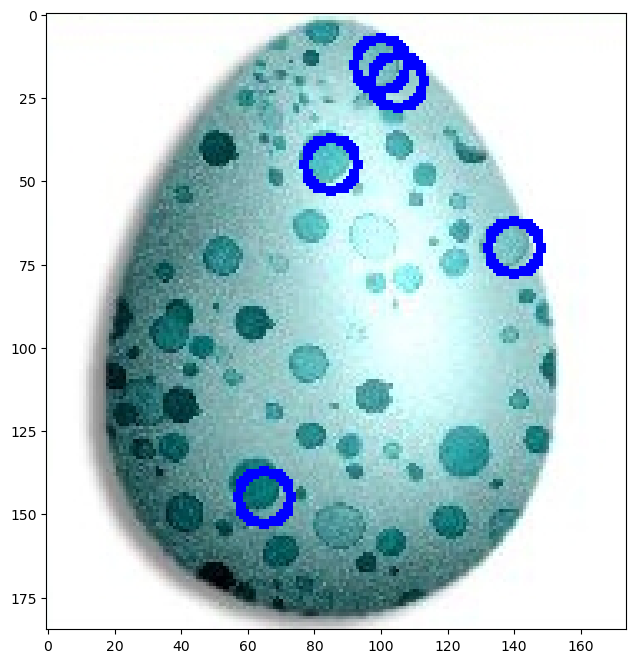

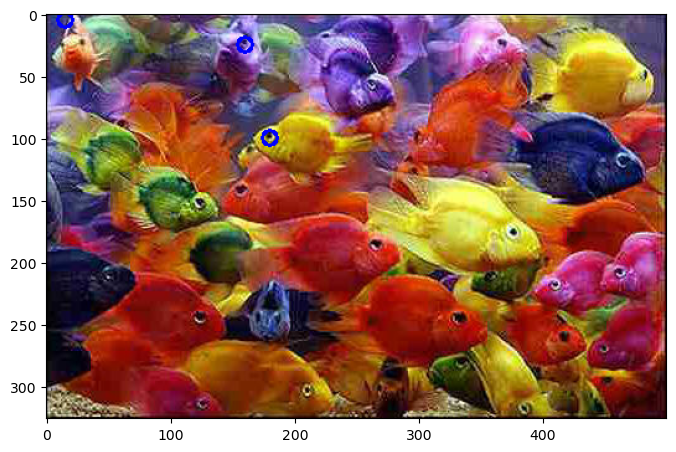

In [87]:
# Visualizations for part I.3
img = cv2.imread('images/egg.jpg')
edges = detect_edges(img, 0.5, False)
centers = detect_circles(img, edges, 8, 5)

img2 = cv2.imread('images/fish.jpg')
edges2 = detect_edges(img2, 100, False)
centers2 = detect_circles(img2, edges2, 6, 3)


## Part II: Image segmentation with K-means (40 points)

For this problem, you will "quantize" a color space by applying k-means clustering to the pixels. You will map each pixel in the input image to its nearest k-means center. That is, you will replace the R,G,B value at each pixel with the average R,G,B value in the cluster to which that pixel belongs. This reduces the amount of information carried by the image, since pixels that had different colors now have the same color. It is also a form of segmentation, since there is only a small number of colors, and the ID of the cluster to which an image pixel belongs is the same as the pixel's color. Note that the RGB values should be treated jointly as the 3-dimensional representation of your pixel.

1. [30 pts - manually graded] `def quantize_RGB(img, k) return output_img, mean_colors, cluster_ids` which performs clustering in the 3-dimensional RGB space, and "quantizes" the image. Use the Sklearn-Python function KMeansLinks to an external site. (and read the documentation to see how to use it). At the end of your function, show the (1) original and (2) quantized image, in a 1x2 subplot. Make sure to label the figure with the value of k that was used.

    Inputs:
    * `img` is an RGB image of class uint8, and
    * `k` specifies the number of colors to quantize to (i.e. the number of clusters).

    Outputs:
    * `output_img` is an RGB image of class uint8 and the same size as the original image,
    * `mean_colors` is a kx3 array of the k centers (one value for each cluster and each color channel), and
    * `cluster_ids` is a numpixelsx1 matrix (with numpixels = numrows * numcolumns) that says to which cluster each pixel belongs.

    Tip: If the variable `origImg is a 3d matrix (numrowsxnumcolsx3) containing a color image with numpixels pixels (first two dimensions) in each color channel (third dimension), then `X = np.reshape(origImg, (numpixels, 3))`  will yield a matrix with the RGB features as its rows. It is in this space (samples = rows, features = columns) that you want to apply k-means.

2. [10 pts - manually graded] Run your function on the provided image `fish.jpg`. Use three different values of k; display and submit the results. For example, if you set k=2, you might get the following as part of your subplot:

![title](images/quantized_rgb_k2.png)

In [113]:
import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def quantize_RGB(img, k):
    num_rows, num_cols, num_channels = img.shape
    num_pixels = num_rows * num_cols
    X = np.reshape(img, (num_pixels, 3))
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)

    output_img = np.zeros_like(X)
    mean_colors = kmeans.cluster_centers_.astype(np.uint8)
    cluster_ids = kmeans.labels_
    
    for i in range(X.shape[0]):
        output_img[i] = mean_colors[cluster_ids[i]]
        
    output_img = output_img.reshape(num_rows, num_cols, num_channels).astype(np.uint8)
    
    return output_img, mean_colors, cluster_ids

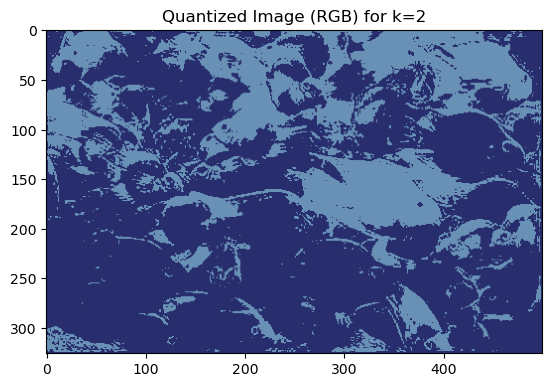

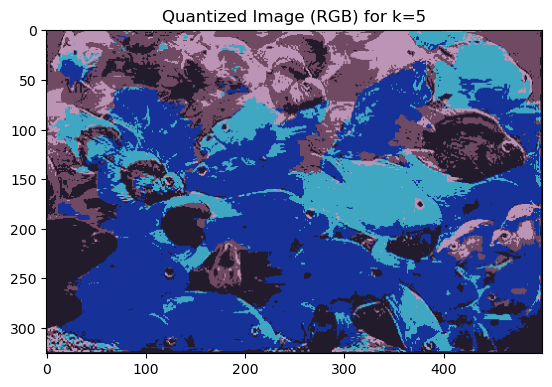

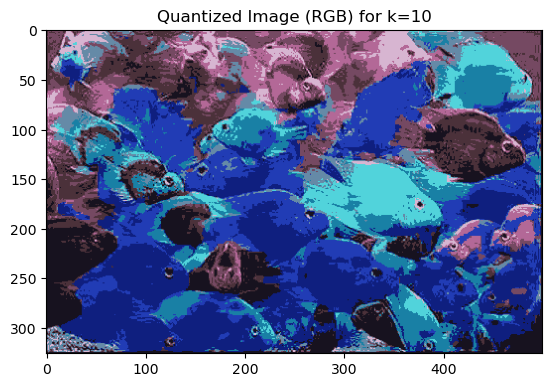

In [114]:
# Visualizations of results for Part II.2
img = cv2.imread('images/fish.jpg')   
try1 = quantize_RGB(img, 2)
plt.title(f"Quantized Image (RGB) for k={2}")
plt.imshow(try1[0])
plt.show()
  
try2 = quantize_RGB(img, 5)
plt.title(f"Quantized Image (RGB) for k={5}")
plt.imshow(try2[0])
plt.show()
 
try3 = quantize_RGB(img, 10)
plt.title(f"Quantized Image (RGB) for k={10}")
plt.imshow(try3[0])
plt.show()

# Acknowledgements
This assignment was adapted from Kristen Grauman's original assignment.

## Only for Graders

This space will be used to test your codes

In [ ]:
#PART I
#img = cv2.imread('images/jupiter.jpg')#.astype(np.float32)
#threshold = 0.05

#edges = detect_edges(img,threshold, True)

#detect_circles(img, edges, 10, 1,True) # un mundo

#img = cv2.imread('images/jupiter.jpg')#.astype(np.float32)
#detect_circles(img, edges, 32, 1,True) # un mundo

#img = cv2.imread('images/jupiter.jpg')#.astype(np.float32)
#detect_circles(img, edges, 52, 1,True)  # otro mundo

#img = cv2.imread('images/jupiter.jpg')#.astype(np.float32)
#detect_circles(img, edges, 100, 1,True)  # otro mundo

In [ ]:
#PART II
#img = cv2.imread('images/fish.jpg')
#k=2
#quant_img_rgb, mean_colors, cluster_ids_rgb = quantize_RGB(img, k)

#k =5
#img = cv2.imread('images/fish.jpg')
#quant_img_rgb, mean_colors, cluster_ids_rgb = quantize_RGB(img, k)


#k=10
#img = cv2.imread('images/fish.jpg')
#quant_img_rgb, mean_colors, cluster_ids_rgb = quantize_RGB(img, k)
